In [23]:
import pickle
import pandas as pd
import numpy as np

file_path = "Statistical_Analysis/statistical_analysis.pkl"
with open(file_path, 'rb') as f:
    data = pickle.load(f)

r_u = data['average_rating_per_user_(r_u)']
user_features = r_u.values.reshape(-1, 1)
summ_ratings = 0
count = 0
for rating in r_u:
    summ_ratings += rating
    count += 1
mu = summ_ratings / count
sum_squared_diff = 0
for rating in r_u:
    diff = rating - mu
    sum_squared_diff += diff ** 2
sigma = np.sqrt(sum_squared_diff / count)
Z_u = (r_u - mu) / sigma
user_features_matrix = []
for z in Z_u:
    user_features_matrix.append(np.array([z]))
user_features_matrix = np.array(user_features_matrix)

class KMeanss:
    def __init__(self, k, max_iters=100, tol=1e-4, random_state=42):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels = []
        self.inertia_ = 0
    def _calculate_distance(self, p1, p2):
        sum_sq_diff = 0.0
        for i in range(len(p1)):
            sum_sq_diff += (p1[i] - p2[i]) ** 2
        return sum_sq_diff ** 0.5

    def fit(self, X):
        np.random.seed(self.random_state)
        n_samples = len(X)
        n_features = len(X[0])
        random_indices = np.random.choice(n_samples, self.k, replace=True)
        self.centroids = []
        for idx in random_indices:
            self.centroids.append(X[idx].copy())
        
        for iteration in range(self.max_iters):
            current_labels = []
            for i in range(n_samples):
                point = X[i]
                min_dist = float('inf')
                closest_centroid_idx = -1
                
                for j in range(self.k):
                    centroid = self.centroids[j]
                    dist = self._calculate_distance(point, centroid)
                    
                    if dist < min_dist:
                        min_dist = dist
                        closest_centroid_idx = j
                
                current_labels.append(closest_centroid_idx)
            
            self.labels = current_labels
            new_centroids = []
            cluster_sums = [[0.0] * n_features for _ in range(self.k)]
            cluster_counts = [0] * self.k
            
            for i in range(n_samples):
                cluster_idx = self.labels[i]
                point = X[i]
                cluster_counts[cluster_idx] += 1
                for f in range(n_features):
                    cluster_sums[cluster_idx][f] += point[f]
            
            for j in range(self.k):
                count_in_cluster = cluster_counts[j]
                if count_in_cluster > 0:
                    new_centroid = []
                    for f in range(n_features):
                        new_centroid.append(cluster_sums[j][f] / count_in_cluster)
                    new_centroids.append(np.array(new_centroid))
                else:
                    new_centroids.append(self.centroids[j])
            total_shift = 0.0
            for j in range(self.k):
                dist = self._calculate_distance(self.centroids[j], new_centroids[j])
                total_shift += dist
            
            self.centroids = new_centroids
            
            if total_shift < self.tol:
                break
        
        # Calculate final Inertia
        inertia_sum = 0.0
        for i in range(n_samples):
            point = X[i]
            cluster_idx = self.labels[i]
            centroid = self.centroids[cluster_idx]
            dist = self._calculate_distance(point, centroid)
            inertia_sum += dist ** 2
            
        self.inertia_ = inertia_sum
        return self

K_values = [5, 10, 15, 20, 30, 50]
clustering_results = {}
kmeans_models = {}
user_clusters = {} 

print(f"Starting Manual K-means for K values: {K_values}")

for k in K_values:
    print(f"Applying K-means with K={k}...")
    kmeans = KMeanss(k=k) 
    kmeans.fit(user_features_matrix)
    kmeans_models[k] = kmeans
    centroids_array = np.array(kmeans.centroids)
    print(f"  > K={k} completed. Centroids shape: {centroids_array.shape}")

cluster_assignments_df = pd.DataFrame(user_clusters, index=r_u.index)
cluster_assignments_df.columns = [f'Cluster_K{k}' for k in K_values]

print(cluster_assignments_df.head())

Starting Manual K-means for K values: [5, 10, 15, 20, 30, 50]
Applying K-means with K=5...
  > K=5 completed. Centroids shape: (5, 1)
Applying K-means with K=10...
  > K=10 completed. Centroids shape: (10, 1)
Applying K-means with K=15...
  > K=15 completed. Centroids shape: (15, 1)
Applying K-means with K=20...
  > K=20 completed. Centroids shape: (20, 1)
Applying K-means with K=30...
  > K=30 completed. Centroids shape: (30, 1)
Applying K-means with K=50...
  > K=50 completed. Centroids shape: (50, 1)

--- Cluster Assignments (First 5 Users) ---
                      Cluster_K5  Cluster_K10  Cluster_K15  Cluster_K20  \
user-id                                                                   
A0040548BPHKXMHH3NTI           3            3           10           11   
A0045750NMY09KVSTE01           1            8            8           16   
A0070287EH1P1FHWO3GW           0            0           13           18   
A0149220O8WD7KG3O5XR           0            6            5            5

--- 7. Analyzing Clustering Results (Sample Size: 1000) ---

Analysis for K = 5:
  WCSS (Inertia): 6130.7152
  Silhouette Score (Sampled): 0.5652

Analysis for K = 10:
  WCSS (Inertia): 2097.3543
  Silhouette Score (Sampled): 0.6022

Analysis for K = 15:
  WCSS (Inertia): 1900.5319
  Silhouette Score (Sampled): 0.6010

Analysis for K = 20:
  WCSS (Inertia): 1284.6911
  Silhouette Score (Sampled): 0.6084

Analysis for K = 30:
  WCSS (Inertia): 471.8197
  Silhouette Score (Sampled): 0.6343

Analysis for K = 50:
  WCSS (Inertia): 304.8533
  Silhouette Score (Sampled): 0.6336


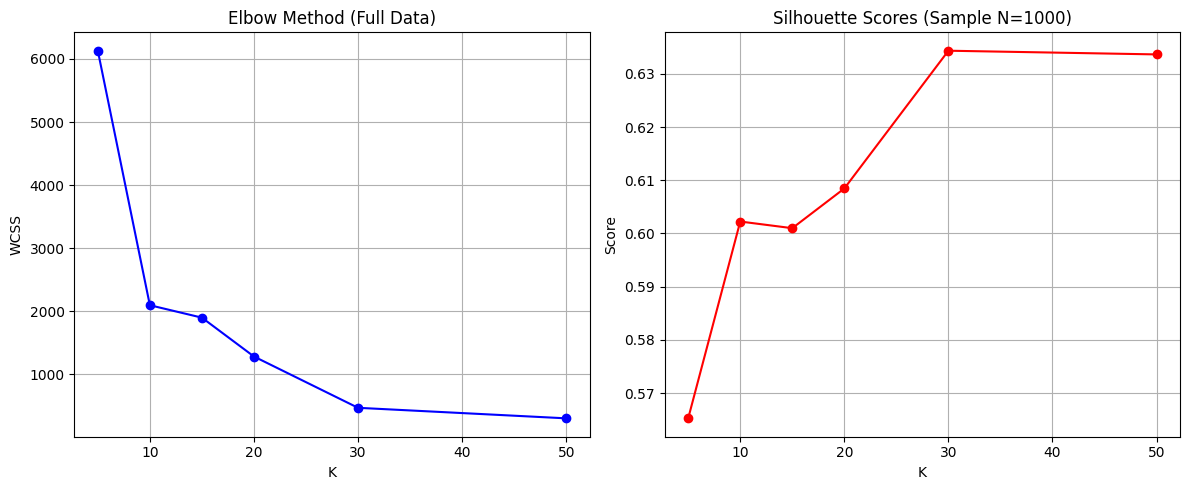

In [32]:
SAMPLE_SIZE = 1000 

def get_distance(p1, p2):
    dist_sq = 0.0
    for i in range(len(p1)):
        dist_sq += (p1[i] - p2[i]) ** 2
    return dist_sq ** 0.5

def calculate_manual_silhouette_sampled(X, labels, sample_size=1000):
    total_samples = len(X)
    if total_samples <= sample_size:
        indices = np.arange(total_samples)
    else:
        np.random.seed(42) 
        indices = np.random.choice(total_samples, sample_size, replace=False)
    X_sample = X[indices]
    labels_array = np.array(labels) 
    labels_sample = labels_array[indices]
    
    n_subset = len(X_sample)
    clusters = {}
    for idx, label in enumerate(labels_sample):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(idx)
        
    unique_labels = list(clusters.keys())
    if len(unique_labels) < 2:
        return 0.0
        
    total_s = 0.0
    
    for i in range(n_subset):
        point_i = X_sample[i]
        label_i = labels_sample[i]
        
        # a(i): Average distance to same cluster
        same_cluster_indices = clusters[label_i]
        
        if len(same_cluster_indices) == 1:
            continue 
            
        dist_sum_a = 0.0
        for idx in same_cluster_indices:
            if idx == i: continue
            dist_sum_a += get_distance(point_i, X_sample[idx])
            
        a_i = dist_sum_a / (len(same_cluster_indices) - 1)
        b_i = float('inf')
        
        for label_j in unique_labels:
            if label_j == label_i: continue
            
            other_indices = clusters.get(label_j, [])
            if not other_indices: continue

            dist_sum_b = 0.0
            for idx in other_indices:
                dist_sum_b += get_distance(point_i, X_sample[idx])
            
            avg_dist_b = dist_sum_b / len(other_indices)
            
            if avg_dist_b < b_i:
                b_i = avg_dist_b
        
        # s(i)
        max_ab = max(a_i, b_i)
        if max_ab == 0:
            s_i = 0.0
        else:
            s_i = (b_i - a_i) / max_ab
            
        total_s += s_i

    return total_s / n_subset
wcss_values = []
silhouette_scores = []

for k in K_values:
    model = kmeans_models[k]
    labels = model.labels 
    
    print(f"\nAnalysis for K = {k}:")
    
    counts = {}
    for lbl in labels:
        counts[lbl] = counts.get(lbl, 0) + 1
    
    wcss = model.inertia_
    wcss_values.append(wcss)
    print(f"  WCSS (Inertia): {wcss:.4f}")
    
    sil_score = calculate_manual_silhouette_sampled(user_features_matrix, labels, SAMPLE_SIZE)
    silhouette_scores.append(sil_score)
    print(f"  Silhouette Score (Sampled): {sil_score:.4f}")

plt.figure(figsize=(12, 5))

# Plot Elbow
plt.subplot(1, 2, 1)
plt.plot(K_values, wcss_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method (Full Data)')
plt.xlabel('K')
plt.ylabel('WCSS')
plt.grid(True)

# Plot Silhouette
plt.subplot(1, 2, 2)
plt.plot(K_values, silhouette_scores, marker='o', linestyle='-', color='r')
plt.title(f'Silhouette Scores (Sample N={SAMPLE_SIZE})')
plt.xlabel('K')
plt.ylabel('Score')
plt.grid(True)

plt.tight_layout()
plt.show()

--- 8. Analyzing Optimal Cluster K=15 ---


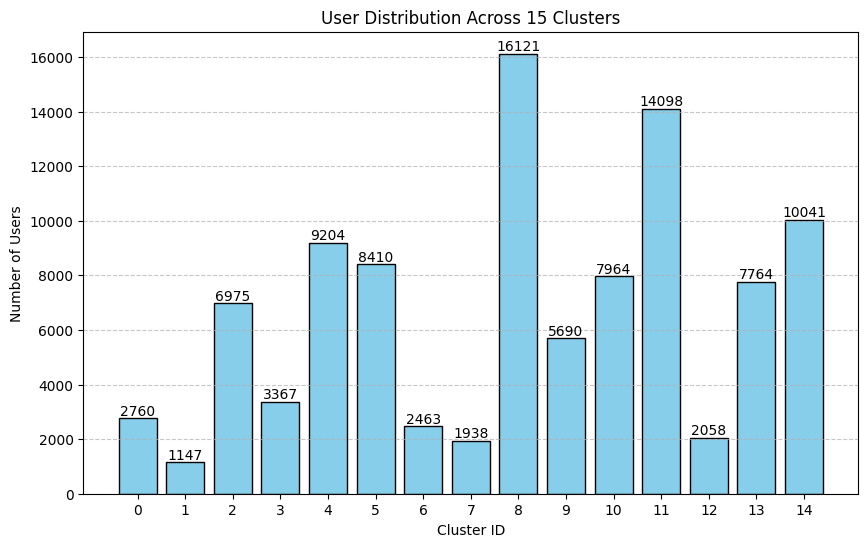


--- 8.2 Cluster Centroids (Sorted by Rating) ---
 Cluster_ID  Average_Rating_Real  User_Count  Centroid_Z_Score
         12             2.182797        2058         -3.169433
          9             2.969616        5690         -1.972518
         14             3.475967       10041         -1.202252
         11             3.873138       14098         -0.598072
         10             4.130350        7964         -0.206799
          4             4.298956        9204          0.049686
          5             4.454840        8410          0.286818
         13             4.587725        7764          0.488965
          2             4.711134        6975          0.676695
          3             4.791260        3367          0.798583
          6             4.848385        2463          0.885483
          0             4.879672        2760          0.933076
          7             4.908772        1938          0.977343
          1             4.943522        1147          1.030206
     

In [34]:
optimal_k = 15 

best_model = kmeans_models[optimal_k]
labels = best_model.labels
centroids_z = np.array(best_model.centroids).flatten() 
cluster_counts = pd.Series(labels).value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue', edgecolor='black')

plt.xlabel('Cluster ID')
plt.ylabel('Number of Users')
plt.title(f'User Distribution Across {optimal_k} Clusters')
plt.xticks(cluster_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.show()

centroid_data = []

for cluster_id, z_score in enumerate(centroids_z):
    # Convert Z-score back to original 1-5 scale
    real_rating = (z_score * sigma) + mu
    
    centroid_data.append({
        'Cluster_ID': cluster_id,
        'Centroid_Z_Score': z_score,
        'Average_Rating_Real': real_rating,
        'User_Count': cluster_counts[cluster_id]
    })

df_analysis = pd.DataFrame(centroid_data).sort_values(by='Average_Rating_Real')

print(df_analysis[['Cluster_ID', 'Average_Rating_Real', 'User_Count', 'Centroid_Z_Score']].to_string(index=False))

strict_cluster = df_analysis.iloc[0]
print(f"Strict Raters: Cluster {int(strict_cluster['Cluster_ID'])} ")
print(f"   > Avg Rating: {strict_cluster['Average_Rating_Real']:.2f} (Users who rarely give 5 stars)")

generous_cluster = df_analysis.iloc[-1]
print(f"Generous Raters: Cluster {int(generous_cluster['Cluster_ID'])} ")
print(f"   > Avg Rating: {generous_cluster['Average_Rating_Real']:.2f} (Users who love everything)")

print("Neutral/Moderate Raters:")
for index, row in df_analysis.iloc[1:-1].iterrows():
    print(f"   > Cluster {int(row['Cluster_ID'])}: Avg Rating {row['Average_Rating_Real']:.2f}")

# 9

In [72]:
user_codes, users = pd.factorize(ratings["user_id"])
item_codes, items = pd.factorize(ratings["item_id"])
n_users, n_items = len(users), len(items)

print("  > Building Sparse Matrix R...")
R = csr_matrix((ratings["rating"].values, (user_codes, item_codes)), shape=(n_users, n_items))

user_map = {u: i for i, u in enumerate(users)}
item_map = {item: i for i, item in enumerate(items)}
item_lookup = {i: item for i, item in enumerate(items)}

user_sums = np.array(R.sum(axis=1)).flatten()
user_counts = np.array((R != 0).sum(axis=1)).flatten()
r_u = user_sums / np.maximum(user_counts, 1)

kmeans = KMeans(n_clusters=15, random_state=42, n_init=10)
kmeans.fit(r_u.reshape(-1, 1))
cluster_labels = kmeans.labels_ 
print("  > Clustering Complete.")

specific_target_users = ['A0040548BPHKXMHH3NTI', 'A100JCBNALJFAW', 'A10175AMUHOQC4']
specific_target_items = ['B00PCSVODW', 'B005GISDXW']

target_user_idxs = []
for u in specific_target_users:
    if u in user_map:
        target_user_idxs.append(user_map[u])
    else:
        print(f"  > Warning: Target User {u} not found in dataset.")

target_item_ids = []
for i in specific_target_items:
    if i in item_map:
        target_item_ids.append(item_map[i])
    else:
        print(f"  > Warning: Target Item {i} not found in dataset.")

print(f"  > Target Users (IDs): {target_user_idxs}")
print(f"  > Target Items (IDs): {target_item_ids}")

def predict_within_cluster_mean_centered(target_idx, cluster_labels, R_matrix, item_indices):
    u_label = cluster_labels[target_idx]
    cluster_indices = np.where(cluster_labels == u_label)[0]

    target_vec = R_matrix[target_idx].toarray().flatten()
    target_mask = target_vec > 0
    if not np.any(target_mask): return {}, 0, u_label
    
    target_mean = target_vec[target_mask].mean()
    target_centered = np.zeros_like(target_vec)
    target_centered[target_mask] = target_vec[target_mask] - target_mean
    target_norm = np.linalg.norm(target_centered)
    
    sims = []
    neighbor_ids = []
    
    for n_idx in cluster_indices:
        if n_idx == target_idx: continue
        
        n_vec = R_matrix[n_idx].toarray().flatten()
        n_mask = n_vec > 0
        if not np.any(n_mask): continue

        n_mean = n_vec[n_mask].mean()
        n_centered = np.zeros_like(n_vec)
        n_centered[n_mask] = n_vec[n_mask] - n_mean
        n_norm = np.linalg.norm(n_centered)
        
        if target_norm > 0 and n_norm > 0:
            sim = np.dot(target_centered, n_centered) / (target_norm * n_norm)
            if sim > 0:
                sims.append(sim)
                neighbor_ids.append(n_idx)
    
    sims = np.array(sims)
    neighbor_ids = np.array(neighbor_ids)
    
    if len(sims) == 0: 
        return {i: float('nan') for i in item_indices}, 0, u_label
        
    k_top = max(1, int(np.ceil(len(sims) * 0.2)))
    if k_top >= len(sims):
        top_idxs = np.arange(len(sims))
    else:
        top_idxs = np.argpartition(-sims, k_top)[:k_top]
        
    top_sims = sims[top_idxs]
    top_neighbors = neighbor_ids[top_idxs]

    preds = {}
    for item_id in item_indices:
        n_ratings = R_matrix[top_neighbors, item_id].toarray().flatten()
        rated_mask = n_ratings > 0
        
        if not np.any(rated_mask):
            preds[item_id] = float('nan')
        else:
            numerator = np.dot(top_sims[rated_mask], n_ratings[rated_mask])
            denominator = np.sum(np.abs(top_sims[rated_mask]))
            
            if denominator == 0:
                preds[item_id] = float('nan')
            else:
                preds[item_id] = numerator / denominator
                
    return preds, len(top_neighbors), u_label

for t_idx in target_user_idxs:
    t_str = users[t_idx]
    print(f"\nProcessing Target User: {t_str} (ID: {t_idx})")
    
    preds, n_neighbors, label = predict_within_cluster_mean_centered(
        t_idx, cluster_labels, R, target_item_ids
    )
    
    print(f"  > Found in Cluster {label}")
    print(f"  > Used {n_neighbors} Neighbors (Top 20% of Cluster)")
    
    for item_id, val in preds.items():
        i_str = item_lookup[item_id]
        if np.isnan(val):
            print(f"    - Item {i_str}: Cannot predict (No neighbors rated it)")
        else:
            print(f"    - Item {i_str}: Predicted Rating = {val:.4f}")

--- 1. Loading Data & Setup ---
  > Loaded C:/Users/bodya/Downloads/dataset/Movies_and_TV.csv (Rows: 8765568)
  > Creating User/Item mappings...
  > Building Sparse Matrix R...

--- 2. Clustering Users (K=15) ---
  > Clustering Complete.

--- 3. Target Setup ---
  > Target Users (IDs): [596750, 12973, 44950]
  > Target Items (IDs): [54754, 41494]

--- 9. User-Based CF Within Clusters (Mean-Centered) ---

Processing Target User: A0040548BPHKXMHH3NTI (ID: 596750)
  > Found in Cluster 8
  > Used 195 Neighbors (Top 20% of Cluster)
    - Item B00PCSVODW: Cannot predict (No neighbors rated it)
    - Item B005GISDXW: Cannot predict (No neighbors rated it)

Processing Target User: A100JCBNALJFAW (ID: 12973)
  > Found in Cluster 1
  > Used 240 Neighbors (Top 20% of Cluster)
    - Item B00PCSVODW: Cannot predict (No neighbors rated it)
    - Item B005GISDXW: Cannot predict (No neighbors rated it)

Processing Target User: A10175AMUHOQC4 (ID: 44950)
  > Found in Cluster 0
  > Used 586 Neighbors (T

In [73]:
ratings["rating"] = ratings["rating"].astype(float)
ratings = ratings.groupby(["user_id", "item_id"], as_index=False)["rating"].mean()

user_codes, users = pd.factorize(ratings["user_id"])
item_codes, items = pd.factorize(ratings["item_id"])
n_users, n_items = len(users), len(items)

R = csr_matrix((ratings["rating"].values, (user_codes, item_codes)), shape=(n_users, n_items))

item_lookup = {i: item for i, item in enumerate(items)}
user_map = {u: i for i, u in enumerate(users)}
item_map = {item: i for i, item in enumerate(items)}

user_sums = np.array(R.sum(axis=1)).flatten()
user_counts = np.array((R != 0).sum(axis=1)).flatten()
r_u = user_sums / np.maximum(user_counts, 1)

kmeans = KMeans(n_clusters=15, random_state=42, n_init=10)
kmeans.fit(r_u.reshape(-1, 1))
cluster_labels = kmeans.labels_ 

specific_target_users = ['A0040548BPHKXMHH3NTI', 'A100JCBNALJFAW', 'A10175AMUHOQC4']
specific_target_items = ['B00PCSVODW', 'B005GISDXW']

target_user_idxs = [user_map[u] for u in specific_target_users if u in user_map]
target_item_ids = [item_map[i] for i in specific_target_items if i in item_map]

def predict_ratings_mean_centered(target_idx, neighbor_indices, R_matrix, item_indices):
    target_vec = R_matrix[target_idx].toarray().flatten()
    target_mask = target_vec > 0
    if not np.any(target_mask): return {i: float('nan') for i in item_indices}, 0
    
    target_mean = target_vec[target_mask].mean()
    target_centered = np.zeros_like(target_vec)
    target_centered[target_mask] = target_vec[target_mask] - target_mean
    target_norm = np.linalg.norm(target_centered)
    
    if target_norm == 0: return {i: float('nan') for i in item_indices}, 0
  
    sims = []
    valid_neighbors = []

    for n_idx in neighbor_indices:
        if n_idx == target_idx: continue
        
        n_vec = R_matrix[n_idx].toarray().flatten()
        n_mask = n_vec > 0
        if not np.any(n_mask): continue
        
        n_mean = n_vec[n_mask].mean()
        n_centered = np.zeros_like(n_vec)
        n_centered[n_mask] = n_vec[n_mask] - n_mean
        n_norm = np.linalg.norm(n_centered)
        
        if n_norm > 0:
            sim = np.dot(target_centered, n_centered) / (target_norm * n_norm)
            if sim > 0: 
                sims.append(sim)
                valid_neighbors.append(n_idx)

    sims = np.array(sims)
    valid_neighbors = np.array(valid_neighbors)
    
    if len(sims) == 0: return {i: float('nan') for i in item_indices}, 0
    
    k = max(1, int(np.ceil(len(sims) * 0.2)))
    if k >= len(sims):
        top_idxs = np.arange(len(sims))
    else:
        top_idxs = np.argpartition(-sims, k)[:k]
        
    top_sims = sims[top_idxs]
    top_neighbors = valid_neighbors[top_idxs]

    preds = {}
    for item_id in item_indices:
        n_ratings = R_matrix[top_neighbors, item_id].toarray().flatten()
        rated_mask = n_ratings > 0
        
        if not np.any(rated_mask):
            preds[item_id] = float('nan')
        else:
            num = np.dot(top_sims[rated_mask], n_ratings[rated_mask])
            den = np.sum(np.abs(top_sims[rated_mask]))
            preds[item_id] = num / den if den != 0 else float('nan')
            
    return preds, len(top_neighbors)

results_table = []

for t_idx in target_user_idxs:
    u_str = users[t_idx]
    print(f"\nProcessing User: {u_str}")

    u_label = cluster_labels[t_idx]
    cluster_neighbors = np.where(cluster_labels == u_label)[0]
    print(f"  > Cluster Search Space: {len(cluster_neighbors)} users")
    
    preds_cluster, n_clust = predict_ratings_mean_centered(
        t_idx, cluster_neighbors, R, target_item_ids
    )

    print("  > Global Search Space: 20,000 users (Sampled for speed)")
    np.random.seed(42)
    global_neighbors = np.random.choice(n_users, 20000, replace=False)
    
    preds_global, n_global = predict_ratings_mean_centered(
        t_idx, global_neighbors, R, target_item_ids
    )
    
    # --- COMPARE ---
    for item_id in target_item_ids:
        i_str = item_lookup[item_id]
        
        val_c = preds_cluster.get(item_id, float('nan'))
        val_g = preds_global.get(item_id, float('nan'))
        
        diff = val_c - val_g if (not np.isnan(val_c) and not np.isnan(val_g)) else float('nan')
        
        results_table.append({
            "User": u_str,
            "Item": i_str,
            "Cluster_Pred": val_c,
            "Global_Pred": val_g,
            "Difference": diff,
            "Neighbors_Cluster": n_clust,
            "Neighbors_Global": n_global
        })

df_results = pd.DataFrame(results_table)
pd.options.display.float_format = '{:.4f}'.format
print(df_results.to_string())

--- 1. Loading & Preprocessing ---
  > Loaded C:/Users/bodya/Downloads/dataset/Movies_and_TV.csv

--- 2. Training Clustering Model ---
  > Comparing for 3 Users on 2 Items.

--- 10. Comparing Models: Clustering vs. Global Baseline ---

Processing User: A0040548BPHKXMHH3NTI
  > Cluster Search Space: 505583 users
  > Global Search Space: 20,000 users (Sampled for speed)

Processing User: A100JCBNALJFAW
  > Cluster Search Space: 32626 users
  > Global Search Space: 20,000 users (Sampled for speed)

Processing User: A10175AMUHOQC4
  > Cluster Search Space: 46197 users
  > Global Search Space: 20,000 users (Sampled for speed)

--- 10.1 & 10.2 Comparison Table ---
                   User        Item  Cluster_Pred  Global_Pred  Difference  Neighbors_Cluster  Neighbors_Global
0  A0040548BPHKXMHH3NTI  B00PCSVODW           NaN          NaN         NaN                164                 9
1  A0040548BPHKXMHH3NTI  B005GISDXW           NaN          NaN         NaN                164                